### IMPORTS

In [1]:
import os
# Remove warning messages from Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import pickle

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, InputLayer

# Import our classes
from prepare_df import prepare_df
from create_datasets import create_datasets
from model_train_eval import model_train_eval

import tensorflow as tf


/home/marco/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
# Create folders which will hold our results. We also expect the /DATA/ folder with the training images to be in the root dir (created with the 
# notebook in the root dir too)

os.mkdir('./MODELS/')
os.mkdir('./HISTORIES/')
os.mkdir('./PICKLES/')
os.mkdir('./VISUALIZATIONS/')

## DATA LOAD

In [3]:
# Read the train.csv file from Kaggle
df = pd.read_csv('../DATA/train.csv')

df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [3]:
# General parameters that we will keep fixed for all the models

random_state = 42
n_epochs = 100
number_of_classes = 1
# This is where images are stored 
basepath = '../DATA/train_images_resized/'
# Some functions use data_dir as name, so we make these the same
data_dir = basepath 
# These are the columns to exclude from our dataframe when using it in a model 
exclude_cols = ['cancer', 'biopsy', 'invasive', 'patient_id', 'image_id', 'path']
# This is our target variable
target_var = 'cancer'
# We will one hot encode the categorical columns
dummy_cols = ['laterality', 'view', 'density', 'machine_id']


In [4]:
# This is our initial, entire dataset split in train/validate/test splits. From here, we will take samples in case we need 
#to for hyperparameters tuning or for models too big to fit in memory. This is to avoid data leakage (ie we cannot take a 
#10% sample of the dataframe and then take the splits on the entire dataframe, because we risk that in the 10% we used for 
#hyperparameters there are observations from our test set when considering the whole df)


# Settings
test_size = 0.2
splits = 5
sample_fraction = 1

#Take a sample 
df_100 = df.groupby(target_var, group_keys=False).apply(lambda x: x.sample(frac=sample_fraction, random_state=random_state))

# Preprocess df
prep_100 = prepare_df(df_100, target_var=target_var, dummy_cols=dummy_cols, 
                data_dir=data_dir, test_size=test_size, splits=splits, 
                random_state=random_state)

# Create updated df
df_100_prep = prep_100.preprocess_df()

# Execute the train/test split and get train/test set
prep_100.train_test()

# Get the KFold dfs 
dfs_100 = prep_100.KFold()

In [5]:
# This is the dataset with only one big split, to test the final model on the entire dataset

# Settings
test_size = 0.2
splits = 1
sample_fraction = 1

#Take a sample 
df_100_test = df.groupby(target_var, group_keys=False).apply(lambda x: x.sample(frac=sample_fraction, random_state=random_state))

# Preprocess df
prep_100_test = prepare_df(df_100_test, target_var=target_var, dummy_cols=dummy_cols, 
                data_dir=data_dir, test_size=test_size, splits=splits, 
                random_state=random_state)

# Create updated df
df_100_test_prep = prep_100_test.preprocess_df()

# Execute the train/test split and get train/test set
prep_100_test.train_test()

# Get the KFold dfs 
dfs_100_test = prep_100_test.KFold()

## 1. SIMPLE LOGIT WITH KERAS

### 1.1 Simple logit hyperparameters

#### 1.1.1 Data preparation

In [6]:
## For hyperparameters with unbalanced data, we use the 10% of the dataframe, without adjusting for imbalance

# Settings
sample_fraction = 0.10

# Train set from before
df_train_100 = prep_100.df_train

#Take a sample from train df and prepare the splits 
df_10 = df_train_100.groupby(target_var, group_keys=False).apply(lambda x: x.sample(frac=sample_fraction, random_state=random_state))

# Preprocess df (remember that we don't need dummy cols as we already converted them before)
prep_10 = prepare_df(df_10, target_var=target_var, dummy_cols=[], 
                data_dir=data_dir, test_size=test_size, splits=splits, 
                random_state=random_state)

# Create updated df
df_10_prep = prep_10.preprocess_df()

# Execute the train/test split and get train/test set
prep_10.train_test()

# Get the KFold dfs 
dfs_10 = prep_10.KFold()


#### 1.1.2 Batch Size, Image Size, Regularization training

In [6]:
## Set parameters
img_size = (512, 512)
n_channels = 1
batch_size = 128

#Create the model
# Design model
number_of_features = img_size

# Helper function to do tuning on regularization type
def reg_wrapper(type, value):
    if type == 'l2':
        return tf.keras.regularizers.l2(value)
    if type == 'l1':
        return tf.keras.regularizers.l1(value)
        
# Architecture

def build(hp):

    # Regularization hyperparameter
    reg = reg_wrapper(hp.Choice('type', ['l1', 'l2']), hp.Float('reg_value', min_value=0.01, max_value=0.05))
    # Image size hyperparameter
    img_sizes = hp.Choice(name='img_sizes', values=[128, 256, 512])

    
    model = Sequential()
    model.add(keras.layers.Resizing(img_sizes, img_sizes))
    model.add(InputLayer(input_shape=(img_sizes, img_sizes, n_channels), name='input'))
    model.add(Flatten(name='flatten_layer'))
    # Regularization hyperparameter is in the last dense layer
    model.add(Dense(number_of_classes, activation='sigmoid', kernel_regularizer=reg, name='logit_layer'))
    
    return model
    

# Train tuners
simple_logit_hyper = model_train_eval(dfs_10, './MODELS/simple_logit_hyper_', 
                                basepath, img_size=img_size, n_channels=n_channels, batch_size=batch_size,
                                random_state=random_state, n_epochs=n_epochs, double_input=False)

sl_tuners = simple_logit_hyper.train_validate_hyper(build, resizing=img_size)

Trial 10 Complete [00h 01m 32s]
val_loss: 0.5028931498527527

Best val_loss So Far: 0.2738739252090454
Total elapsed time: 00h 21m 14s
INFO:tensorflow:Oracle triggered exit


In [7]:
# Build a dataframe with the best values per trial and fold
trials_summary = pd.DataFrame()

# Iterate over folds and trials to collect metrics and hyperparameter values
for fold in range(len(sl_tuners)):
    t = sl_tuners[fold]
    trials = t.oracle.trials

    for trial in trials:
        json_batch = trials[trial].get_state()
        trial_id = {'trial_id': trial}
        hyper = {key: val for key, val in json_batch['hyperparameters']['values'].items()}
        metrics = {key: val['observations'][0]['value'][0] for key, val in json_batch['metrics']['metrics'].items()}

        metrics.update(trial_id)
        metrics.update(hyper)

        metrics = pd.DataFrame(metrics, index=[0])

        metrics['fold'] = fold

        trials_summary = pd.concat([trials_summary, metrics])

#Create dummy for categorical reg_type

group_vars = trials_summary['type'].unique()
dfg = pd.DataFrame({'type':trials_summary['type'].unique()})
dfg['dummy'] = dfg.index
trials_summary = pd.merge(trials_summary, dfg, on='type', how='left')

trials_summary.to_pickle('./PICKLES/sl_tuner.pkl')

In [8]:
# Build a parallel coordinates plot

dimensions = list([ dict(range=[trials_summary['img_sizes'].min(),trials_summary['img_sizes'].max()],
                        label='Image size', values=trials_summary['img_sizes']),  
                    
                    dict(range=[trials_summary['batch_size'].min(),trials_summary['batch_size'].max()],
                        label='Batch size', values=trials_summary['batch_size']),

                   dict(range=[0,trials_summary['dummy'].max()],
                        tickvals = dfg['dummy'], ticktext = dfg['type'],
                        label='Regularization type', values=trials_summary['dummy']),

                   dict(range=[trials_summary['reg_value'].min(),trials_summary['reg_value'].max()],
                        label='Regularization value', values=trials_summary['reg_value']),     

                   dict(range=[trials_summary['val_loss'].min(),trials_summary['val_loss'].max()],
                        label='Validation loss', values=trials_summary['val_loss']),   
                  ])


fig = go.Figure(data=go.Parcoords(line = dict(color = trials_summary['val_loss'], colorscale='Tealrose', showscale = True),
                                  dimensions=dimensions
                                   )
               )
                                  
fig.show()

In [9]:
# Get best hyperparameters
best_per_fold = trials_summary.groupby('fold')['val_loss'].idxmin()
trials_summary.iloc[best_per_fold]

,loss,auc,precision,recall,f1_score,val_loss,val_auc,val_precision,val_recall,val_f1_score,lr,trial_id,type,reg_value,img_sizes,batch_size,fold,dummy
5,0.893252,0.567015,0.020455,0.482143,0.039244,0.197862,0.511721,0.0,0.0,0.0,0.001,05,l2,0.028566,128,128,0,0
13,0.872799,0.738260,0.044248,0.701754,0.083247,0.245010,0.550797,0.0,0.0,0.0,0.001,03,l2,0.027625,128,16,1,0
27,1.008633,0.501250,0.018868,0.482143,0.036315,0.329057,0.591287,0.0,0.0,0.0,0.001,07,l2,0.015509,128,80,2,0
38,1.061126,0.647110,0.031107,0.586207,0.059079,0.244254,0.351873,0.0,0.0,0.0,0.001,08,l2,0.043236,256,128,3,0
40,0.704254,0.775829,0.053801,0.807018,0.100877,0.273874,0.501584,0.0,0.0,0.0,0.001,00,l2,0.031098,128,64,4,0


Best values for  simple logit: batch size 128, image size 128, regularization type L2, Regularization value 0.025.

### 1.2 MODEL PERFORMANCE

In [21]:
## Set parameters
img_size = (128, 128)
n_channels = 1
batch_size = 128

#Create the model
# Design model
number_of_features = img_size

# Architecture
sl_model = Sequential()
sl_model.add(keras.layers.Resizing(img_size[0], img_size[1]))
sl_model.add(InputLayer(input_shape=(img_size[0], img_size[1], n_channels), name='input'))
sl_model.add(Flatten(name='flatten_layer'))
sl_model.add(Dense(number_of_classes, activation='sigmoid', kernel_regularizer=keras.regularizers.L2(0.025), name='logit_layer'))

# Train it on the entire training data
simple_logit = model_train_eval(dfs_100_test, './MODELS/simple_logit', splits=splits,
                                basepath=basepath, img_size=img_size, n_channels=n_channels, batch_size=batch_size, 
                                random_state=random_state, n_epochs=n_epochs, double_input=False)

sl_history = simple_logit.train_validate(sl_model, resizing=img_size, disk_cache=False)


>>>> TRAINING FOLD 0
Epoch 1/100
274/274 [==============================] - 198s 703ms/step - loss: 0.9456 - auc: 0.5172 - precision: 0.0212 - recall: 0.4966 - f1_score: 0.0407 - val_loss: 0.7008 - val_auc: 0.5344 - val_precision: 0.0231 - val_recall: 0.4149 - val_f1_score: 0.0438 - lr: 0.0010
Epoch 2/100
274/274 [==============================] - 7s 27ms/step - loss: 0.8370 - auc: 0.5619 - precision: 0.0253 - recall: 0.5572 - f1_score: 0.0485 - val_loss: 0.5017 - val_auc: 0.5601 - val_precision: 0.0206 - val_recall: 0.0957 - val_f1_score: 0.0339 - lr: 0.0010
Epoch 3/100
274/274 [==============================] - 7s 26ms/step - loss: 0.8072 - auc: 0.5796 - precision: 0.0260 - recall: 0.5462 - f1_score: 0.0497 - val_loss: 0.8963 - val_auc: 0.5369 - val_precision: 0.0240 - val_recall: 0.7660 - val_f1_score: 0.0465 - lr: 0.0010
Epoch 4/100
274/274 [==============================] - 7s 26ms/step - loss: 0.7936 - auc: 0.5996 - precision: 0.0284 - recall: 0.5834 - f1_score: 0.0541 - val_loss

In [22]:
# Save the model and history as pickle
with open('./HISTORIES/sl_model.pkl', 'wb') as f:
    pickle.dump(sl_history, f)
with open('./MODELS/sl_model.pkl', 'wb') as f:
    pickle.dump(sl_model, f);

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......flatten
.........vars
......input_layer
.........vars
......resizing
.........vars
...metrics
......auc
.........vars
............0
............1
............2
............3
......f1_score
.........vars
............0
............1
............2
............3
......mean
.........vars
............0
............1
......precision
.........vars
............0
............1
......recall
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-04-18 19:47:50         3000
variables.h5                                   2023-04-18 19:47:50       231200
metadata.json                                  2023-04-18 19:47:50           64
Kera

In [23]:
# Print a summary of the mode
sl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 128, 128, 1)       0         
                                                                 
 input (InputLayer)          multiple                  0         
                                                                 
 flatten_layer (Flatten)     (None, 16384)             0         
                                                                 
 logit_layer (Dense)         (None, 1)                 16385     
                                                                 
Total params: 16,385
Trainable params: 16,385
Non-trainable params: 0
_________________________________________________________________


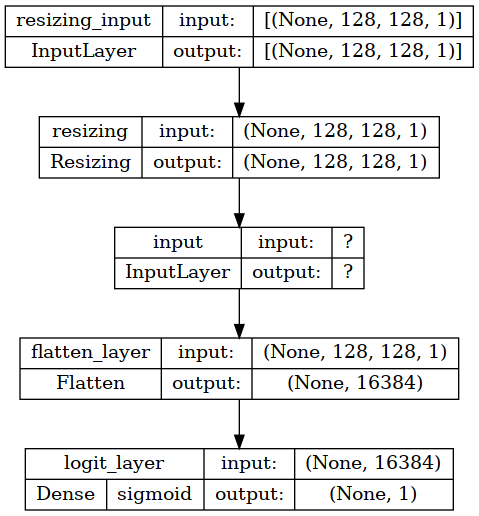

In [24]:
# Plot the model layers
tf.keras.utils.plot_model(sl_model, to_file='./VISUALIZATIONS/simple_logit.png', show_shapes=True, show_layer_activations=True)

In [9]:
# Create the test data and make predictions on probabilities and classes
create_test = create_datasets(dfs_100_test, fold=0, target_var=target_var, 
                img_var='path', exclude_cols=[], 
                double_input=False)

test = create_test.create_ds('test', resizing=img_size)

test = create_test.configure_for_performance(test, batch_size=batch_size, train=False)


y_pred = sl_model.predict(test)

y_class = np.where(y_pred >= 0.5, 1, 0)

# Save the variables for comparison later
y_pred_sl, y_class_sl = y_pred, y_class

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
86/86 [==============================] - 47s 509ms/step


In [26]:
# Print activations

# Take a sample batch from the test set
for imgs, labels in test.take(1):
    original_labels = labels.numpy()
    # Get positive and negative labels - we aim to have max 5 positive and 5 negative examples
    positive_labels = np.where(original_labels == 1)[0]
    negative_labels = np.where(original_labels == 0)[0]
    if len(positive_labels) > 5:
        positive_labels = positive_labels[:5]
    
    negative_labels = negative_labels[:10-len(positive_labels)]
    # Indices to our images
    labels_idx = np.concatenate((negative_labels, positive_labels))

    original_imgs = imgs.numpy()
    original_imgs = original_imgs[labels_idx]
    
    original_labels = original_labels[labels_idx]

# Make prediction to show last activation layer
sl_activation = sl_model.predict(original_imgs)

1/1 [==============================] - 0s 315ms/step


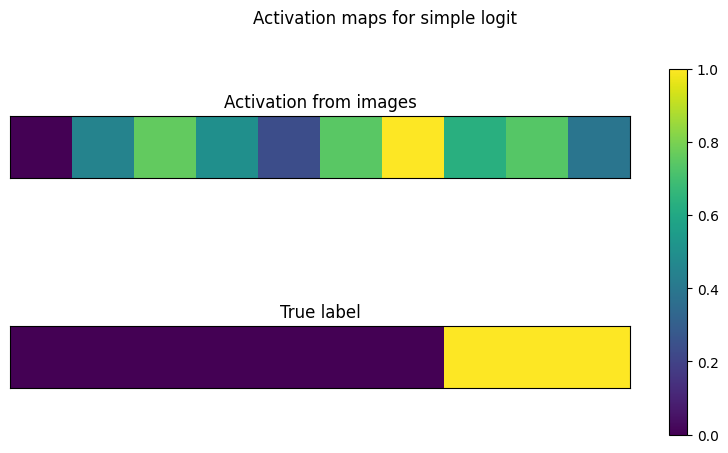

In [27]:
# Plot activations
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,5))

# Display activation from images
ax = axs[0]
im = ax.imshow(sl_activation.reshape([1, 10]))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Activation from images')

# Display true label
ax = axs[1]
im = ax.imshow(original_labels.reshape([1, 10]))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('True label')

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95)

fig.suptitle('Activation maps for simple logit')
plt.show()

In [28]:
# Evaluate the model
sl_results = sl_model.evaluate(test)

86/86 [==============================] - 2s 21ms/step - loss: 0.6732 - auc: 0.5681 - precision: 0.0267 - recall: 0.3959 - f1_score: 0.0501


In [10]:
# This is our true label from the test set
y_test = [label for (imgs, label_batch) in test.as_numpy_iterator() for label in label_batch]

# Save it for comparison
y_test_sl = y_test

# Get the confusion matrix
confusion = confusion_matrix(y_test, y_class)
print(confusion)

[[7163 3531]
 [ 148   97]]


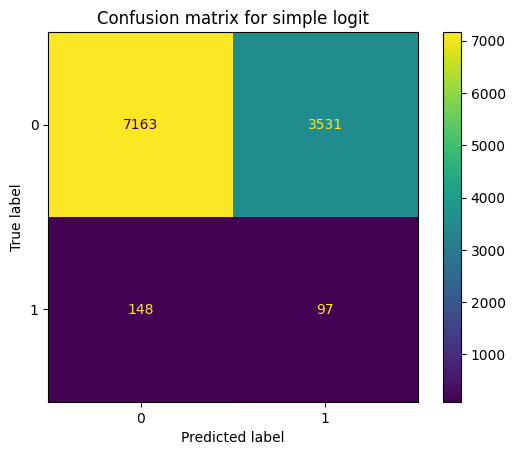

In [30]:
# Plot the confusion matrix
im = ConfusionMatrixDisplay.from_predictions(y_test, y_class)
im.ax_.set_title('Confusion matrix for simple logit');

In [31]:
# Print the classification report
print(classification_report(y_test, y_class))

              precision    recall  f1-score   support

           0       0.98      0.67      0.80     10694
           1       0.03      0.40      0.05       245

    accuracy                           0.66     10939
   macro avg       0.50      0.53      0.42     10939
weighted avg       0.96      0.66      0.78     10939



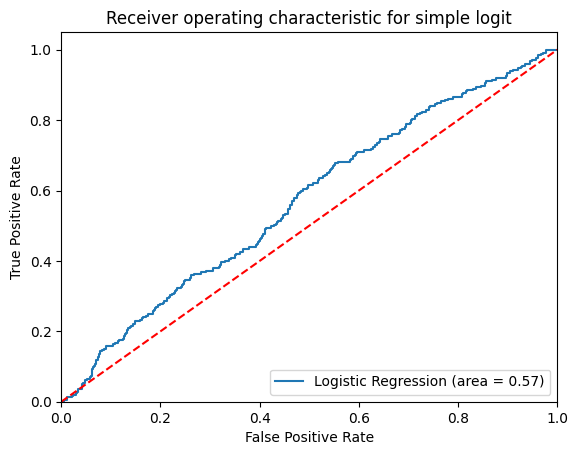

In [32]:
# Plot the ROC curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for simple logit')
plt.legend(loc='lower right')
plt.savefig('./VISUALIZATIONS/Simple_Logit_ROC.png')
plt.show()

## 2. LOGIT WITH MULTIPLE INPUTS

No need for hyperparameters testing as the logit model remains the same, we just combine the output with the dataframe data. We do, however, need to clean the data from NaN and create new datasets:

#### 2.1 Data Preparation

In [11]:
# We create a new train, validate, test split on the whole dataset but cleaned for NaN

# Settings
test_size = 0.2
splits = 1
sample_fraction = 1

# We clean the dataset from NaNs 
df_clean = df.dropna()

#Take a sample 
df_100_clean = df_clean.groupby(target_var, group_keys=False).apply(lambda x: x.sample(frac=sample_fraction, random_state=random_state))

# Preprocess df
prep_100_clean = prepare_df(df_100_clean, target_var=target_var, dummy_cols=dummy_cols, 
                                data_dir=data_dir, test_size=test_size, splits=splits, 
                                random_state=random_state)

# Create updated df
df_100_clean_prep = prep_100_clean.preprocess_df()

# Execute the train/test split and get train/test set
prep_100_clean.train_test()

# Get the KFold dfs (for split 1 it's just 1 big train/val/test split)
dfs_100_clean = prep_100_clean.KFold()

#### 2.2 Final Model

In [25]:

## Set parameters
input_size = (128, 128)
img_size = (128, 128)
n_channels = 1
batch_size = 128

#Create the model
# Design model
number_of_features = img_size

# Architecture
input_img = keras.Input((*input_size, n_channels), name='input_image')
resize_img = keras.layers.Resizing(*img_size, name='resizing')(input_img)
input_df = keras.Input(len(prep_100_clean.df_test.columns)-len(exclude_cols), name='input_dataframe')

# Branch on image

A = Flatten(name='flatten_layer')(input_img)
A = Dense(number_of_classes, activation='sigmoid', kernel_regularizer=keras.regularizers.L2(0.025), name='logit_layer_img')(A)
A = keras.Model(inputs=input_img, outputs=A)

# Branch on dataframe

B = Dense(number_of_classes, activation='sigmoid', name='logit_layer_df')(input_df)
B = keras.Model(inputs=input_df, outputs=B)

# Concatenate
combined = keras.layers.Concatenate()([A.output, B.output])

# Final prediction

final = Dense(number_of_classes, activation='sigmoid')(combined)

asl_model = keras.Model(inputs=[A.input, B.input], outputs=final)

a_simple_logit = model_train_eval(dfs_100_clean, './MODELS/augmented_simple_logit', splits=splits, exclude_cols=exclude_cols,
                                basepath=basepath, img_size=img_size, n_channels=n_channels, batch_size=batch_size, 
                                random_state=random_state, n_epochs=n_epochs, double_input=True)

asl_history = a_simple_logit.train_validate(asl_model, resizing=img_size, disk_cache=False)

>>>> TRAINING FOLD 0
Epoch 1/100
119/119 [==============================] - 96s 744ms/step - loss: 0.7010 - auc: 0.4871 - precision: 0.0275 - recall: 0.7395 - f1_score: 0.0530 - val_loss: 0.6902 - val_auc: 0.5237 - val_precision: 0.0297 - val_recall: 0.9904 - val_f1_score: 0.0576 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - 4s 33ms/step - loss: 0.6930 - auc: 0.4819 - precision: 0.0283 - recall: 0.7674 - f1_score: 0.0546 - val_loss: 0.6925 - val_auc: 0.5218 - val_precision: 0.0289 - val_recall: 1.0000 - val_f1_score: 0.0561 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - 4s 31ms/step - loss: 0.6933 - auc: 0.4943 - precision: 0.0277 - recall: 0.7628 - f1_score: 0.0535 - val_loss: 0.6951 - val_auc: 0.5033 - val_precision: 0.0289 - val_recall: 1.0000 - val_f1_score: 0.0561 - lr: 0.0010
Epoch 4/100
119/119 [==============================] - 4s 33ms/step - loss: 0.6949 - auc: 0.4906 - precision: 0.0284 - recall: 0.8209 - f1_score: 0.0548 - val_loss:

In [26]:
# Save the hostory and model as pickle
with open('./HISTORIES/asl_model.pkl', 'wb') as f:
    pickle.dump(asl_history, f)
with open('./MODELS/asl_model.pkl', 'wb') as f:
    pickle.dump(asl_model, f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......flatten
.........vars
......input_layer
.........vars
......input_layer_1
.........vars
...metrics
......auc
.........vars
............0
............1
............2
............3
......f1_score
.........vars
............0
............1
............2
............3
......mean
.........vars
............0
............1
......precision
.........vars
............0
............1
......recall
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
conf

In [27]:
# Print model summary
asl_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 flatten_layer (Flatten)        (None, 16384)        0           ['input_image[0][0]']            
                                                                                                  
 input_dataframe (InputLayer)   [(None, 24)]         0           []                               
                                                                                                  
 logit_layer_img (Dense)        (None, 1)            16385       ['flatten_layer[0][0]']    

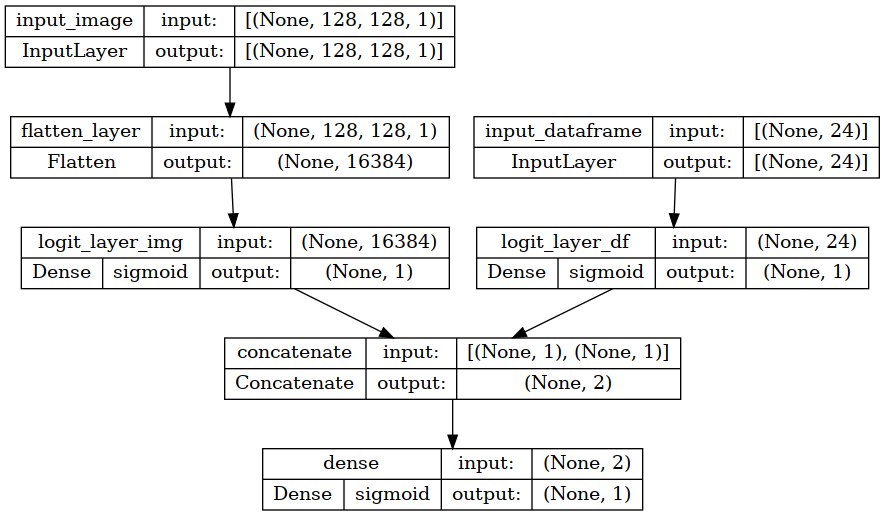

In [28]:
# Plot model layers
tf.keras.utils.plot_model(asl_model, to_file='./VISUALIZATIONS/augmented_logit.png', show_shapes=True, show_layer_activations=True)

In [13]:
# Create the test data and make predictions on probabilities and classes
create_test_double = create_datasets(dfs_100_clean, fold=0, target_var=target_var, 
                    img_var='path', exclude_cols=exclude_cols, 
                     double_input=True)

test_double = create_test_double.create_ds('test', resizing=img_size)

test_double = create_test_double.configure_for_performance(test_double, batch_size=batch_size, train=False)

y_pred = asl_model.predict(test_double)

y_class = np.where(y_pred > 0.50, 1, 0)

y_test = [label for (imgs, label_batch) in test_double.as_numpy_iterator() for label in label_batch]

# Save for comparison later

y_pred_asl, y_class_asl, y_test_asl = y_pred, y_class, y_test

37/37 [==============================] - 18s 496ms/step


In [30]:
# Evaluate model
asl_results = asl_model.evaluate(test_double)

37/37 [==============================] - 2s 26ms/step - loss: 0.7042 - auc: 0.5175 - precision: 0.0289 - recall: 1.0000 - f1_score: 0.0562


In [31]:
# Print activations

for (imgs, data), labels in test_double.take(1):
    original_labels = labels.numpy()
    positive_labels = np.where(original_labels == 1)[0]
    negative_labels = np.where(original_labels == 0)[0]
    if len(positive_labels) > 5:
        positive_labels = positive_labels[:5]
    
    negative_labels = negative_labels[:10-len(positive_labels)]
    labels_idx = np.concatenate((negative_labels, positive_labels))

    original_imgs = imgs.numpy()
    original_imgs = original_imgs[labels_idx]

    original_data = data.numpy()
    original_data = original_data[labels_idx]
    
    original_labels = original_labels[labels_idx]

A_activation = A.predict(original_imgs)
B_activation = B.predict(original_data)

asl_activation = asl_model.predict((original_imgs, original_data))   

1/1 [==============================] - 0s 196ms/step


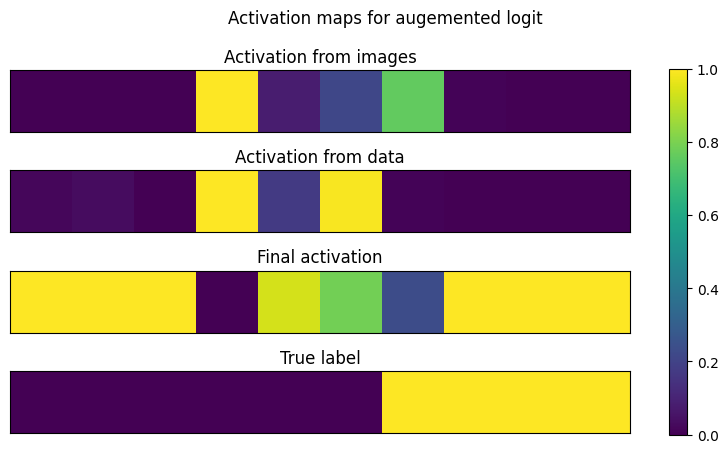

In [32]:

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10,5))

# Display A activation (image feed)
ax = axs[0]
im = ax.imshow(A_activation.reshape([1, 10]))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Activation from images')

# Display B activation (data feed)
ax = axs[1]
im = ax.imshow(B_activation.reshape([1, 10]))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Activation from data')

# Display combined activation
ax = axs[2]
im = ax.imshow(asl_activation.reshape([1, 10]))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Final activation')

# Display true label
ax = axs[3]
im = ax.imshow(original_labels.reshape([1, 10]))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('True label')

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95)

fig.suptitle('Activation maps for augemented logit')
plt.show()

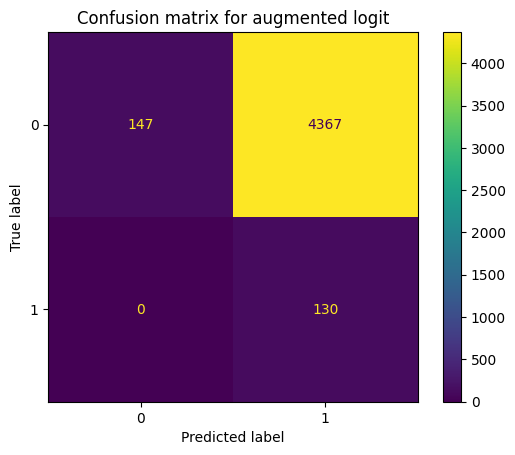

In [33]:
# Display confusion matrix
im = ConfusionMatrixDisplay.from_predictions(y_test, y_class)
im.ax_.set_title('Confusion matrix for augmented logit');

In [34]:
# Print classification report
print(classification_report(y_test, y_class))

              precision    recall  f1-score   support

           0       1.00      0.03      0.06      4514
           1       0.03      1.00      0.06       130

    accuracy                           0.06      4644
   macro avg       0.51      0.52      0.06      4644
weighted avg       0.97      0.06      0.06      4644



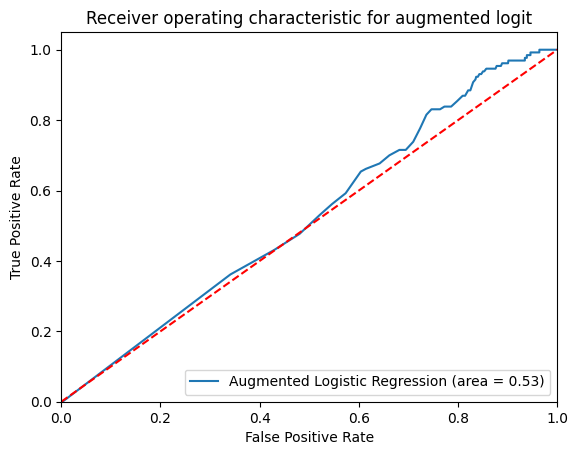

In [35]:
# Plot ROC Curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Augmented Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for augmented logit')
plt.legend(loc='lower right')
plt.savefig('./VISUALIZATIONS/Augmented_Logit_ROC.png')
plt.show()

## 3. LOGIT WITH AUTOENCODER

#### 3.1 AUTOENCODER HYPERPARAMETERS

As data feed we use the same 10% sample used for the simple logit hyperparameters tuning.

In [6]:
### FROM https://blog.keras.io/building-autoencoders-in-keras.html

## Set parameters
img_size = (512, 512)
input_size = (512, 512)
n_channels = 1
batch_size = 128

# Architecture
def reg_wrapper(type, value):
    if type == 'l2':
        return tf.keras.regularizers.l2(value)
    if type == 'l1':
        return tf.keras.regularizers.l1(value)

def build(hp):

    # Regularization hyperparameter
    reg = reg_wrapper(hp.Choice('type', ['l1', 'l2']), hp.Float('reg_value', min_value=0.01, max_value=0.05))
    # Encoding dim hyperparameter
    encoding_dim = hp.Choice(name='encoding_dim', values=[16, 64])


    # This is our input image
    input_img = keras.Input(shape=(*input_size,), name='input_image')
    flatten = keras.layers.Flatten(name='flatten_layer')(input_img)
    # "encoded" is the encoded representation of the input
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name='encoder_layer')(flatten)
    # "decoded" is the lossy reconstruction of the input (sigmoid as our original images are [0, 1])
    decoded = keras.layers.Dense(img_size[0]*img_size[1], activation='sigmoid', kernel_regularizer=reg, name='decoder_layer')(encoded)
    reshaped = keras.layers.Reshape((img_size[0], img_size[1],), name='reshape_layer')(decoded)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_img, reshaped)

    # This model maps an input to its encoded representation
    encoder = keras.Model(input_img, encoded)

    # This is our encoded input
    encoded_input = keras.Input(shape=(encoding_dim,))
    # Retrieve the second last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-2]
    # Create the decoder model
    decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
    
    return autoencoder


autoencoder_hyper = model_train_eval(dfs_10, './MODELS/autoencoder_hyper', splits=splits,
                                    basepath=basepath, img_size=img_size, n_channels=n_channels, batch_size=batch_size, 
                                    random_state=random_state, n_epochs=n_epochs, double_input=False)

autoencoder_tuners = autoencoder_hyper.train_validate_hyper(build, resizing=img_size, disk_cache=False, autoencoder=True)

Trial 10 Complete [00h 04m 41s]
val_loss: 0.16133879125118256

Best val_loss So Far: 0.031922150403261185
Total elapsed time: 00h 22m 00s
INFO:tensorflow:Oracle triggered exit


In [7]:
# Build a dataframe with the best values per trial and fold
trials_summary = pd.DataFrame()

# Iterate over folds and trials to collect metrics and hyperparameter values
for fold in range(len(autoencoder_tuners)):
    t = autoencoder_tuners[fold]
    trials = t.oracle.trials

    for trial in trials:
        json_batch = trials[trial].get_state()
        trial_id = {'trial_id': trial}
        hyper = {key: val for key, val in json_batch['hyperparameters']['values'].items()}
        metrics = {key: val['observations'][0]['value'][0] for key, val in json_batch['metrics']['metrics'].items()}

        metrics.update(trial_id)
        metrics.update(hyper)

        metrics = pd.DataFrame(metrics, index=[0])

        metrics['fold'] = fold

        trials_summary = pd.concat([trials_summary, metrics])

#Create dummy for categorical reg_type

group_vars = trials_summary['type'].unique()
dfg = pd.DataFrame({'type':trials_summary['type'].unique()})
dfg['dummy'] = dfg.index
trials_summary = pd.merge(trials_summary, dfg, on='type', how='left')

trials_summary.to_pickle('./PICKLES/auto_tuner.pkl')

In [8]:
# Build a parallel coordinates plot

dimensions = list([ dict(range=[trials_summary['encoding_dim'].min(),trials_summary['encoding_dim'].max()],
                        label='Encoding dimensions', values=trials_summary['encoding_dim']),  
                    
                    dict(range=[trials_summary['batch_size'].min(),trials_summary['batch_size'].max()],
                        label='Batch size', values=trials_summary['batch_size']),

                   dict(range=[0,trials_summary['dummy'].max()],
                        tickvals = dfg['dummy'], ticktext = dfg['type'],
                        label='Regularization type', values=trials_summary['dummy']),

                   dict(range=[trials_summary['reg_value'].min(),trials_summary['reg_value'].max()],
                        label='Regularization value', values=trials_summary['reg_value']),     

                   dict(range=[trials_summary['val_loss'].min(),trials_summary['val_loss'].max()],
                        label='Validation loss', values=trials_summary['val_loss']),   
                  ])


fig = go.Figure(data=go.Parcoords(line = dict(color = trials_summary['val_loss'], colorscale='Tealrose', showscale = True),
                                  dimensions=dimensions
                                   )
               )
                                  
fig.show()

In [9]:
# Get best hyperparameters
best_per_fold = trials_summary.groupby('fold')['val_loss'].idxmin()
trials_summary.iloc[best_per_fold]

,loss,cosine_similarity,val_loss,val_cosine_similarity,lr,trial_id,type,reg_value,encoding_dim,batch_size,fold,dummy
0,0.038269,0.831397,0.037515,0.834830,0.00100,00,l2,0.017794,64,64,0,0
19,0.037416,0.834672,0.033569,0.839178,0.00100,09,l2,0.014152,64,112,1,0
26,0.036579,0.827221,0.035662,0.834076,0.00100,06,l2,0.013676,64,16,2,0
37,0.030472,0.856182,0.030448,0.858373,0.00001,07,l2,0.034878,64,48,3,0
47,0.031328,0.850925,0.031922,0.845976,0.00010,07,l2,0.026930,16,48,4,0


In [10]:
# Also by encoding dim
best_per_fold_dim = trials_summary.groupby(['fold', 'encoding_dim'])['val_loss'].idxmin()
trials_summary.iloc[best_per_fold_dim]


,loss,cosine_similarity,val_loss,val_cosine_similarity,lr,trial_id,type,reg_value,encoding_dim,batch_size,fold,dummy
6,0.041620,0.820555,0.042564,0.799512,0.00100,06,l2,0.017146,16,96,0,0
0,0.038269,0.831397,0.037515,0.834830,0.00100,00,l2,0.017794,64,64,0,0
13,0.039008,0.820337,0.035945,0.830334,0.00100,03,l2,0.025235,16,16,1,0
19,0.037416,0.834672,0.033569,0.839178,0.00100,09,l2,0.014152,64,112,1,0
25,0.038747,0.826757,0.040660,0.823008,0.00100,05,l2,0.035709,16,64,2,0
26,0.036579,0.827221,0.035662,0.834076,0.00100,06,l2,0.013676,64,16,2,0
31,0.034860,0.838792,0.034297,0.839321,0.00100,01,l2,0.016770,16,128,3,0
37,0.030472,0.856182,0.030448,0.858373,0.00001,07,l2,0.034878,64,48,3,0
47,0.031328,0.850925,0.031922,0.845976,0.00010,07,l2,0.026930,16,48,4,0
42,0.046519,0.812414,0.047211,0.803311,0.00100,02,l2,0.047716,64,96,4,0


Best hyperparameters are encoding dimensions 64, batch size 48, regularization type L2, regularization value 0.01-0.03. 

#### 3.2 AUTOENCODER PERFORMANCE

In [14]:
# Unfortunately with 512x512 images, the entire test set does not fit in memory. We therefore do the test only on 10% of the dataset

# The training split is taken as a sample for our full training split defined before.

# Settings
test_size = 0.2
splits = 1
sample_fraction = 0.1

#Take a sample 
df_10_test = dfs_100_test[0]['train'].groupby(target_var, group_keys=False).apply(lambda x: x.sample(frac=sample_fraction, random_state=random_state))

# Preprocess df
prep_10_test = prepare_df(df_10_test, target_var=target_var, dummy_cols=[], 
                data_dir=data_dir, test_size=test_size, splits=splits, 
                random_state=random_state)

# Create updated df
df_10_tst_prep = prep_10_test.preprocess_df()

# Execute the train/test split and get train/test set
prep_10_test.train_test()

# Get the KFold dfs 
dfs_10_test = prep_10_test.KFold()

In [8]:
### FROM https://blog.keras.io/building-autoencoders-in-keras.html

## Set parameters
input_size = (512, 512)
img_size = (512, 512)
n_channels = 1
batch_size = 48

#Create the model

# Architecture

# This is the size of our encoded representations
encoding_dim = 64

# This is our input image
input_img = keras.Input(shape=(*input_size,), name='input_image')
flatten = keras.layers.Flatten(name='flatten_layer')(input_img)
# "encoded" is the encoded representation of the input
encoded = keras.layers.Dense(encoding_dim, activation='relu', name='encoder_layer')(flatten)
# "decoded" is the lossy reconstruction of the input (sigmoid as our original images are [0, 1])
decoded = keras.layers.Dense(img_size[0]*img_size[1], activation='sigmoid', kernel_regularizer=keras.regularizers.L2(0.02), name='decoder_layer')(encoded)
reshaped = keras.layers.Reshape((img_size[0], img_size[1],), name='reshape_layer')(decoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, reshaped)

# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

# This is our encoded input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-2]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))


autoenc = model_train_eval(dfs_10_test, './MODELS/autoencoder', splits=splits,
                                basepath=basepath, img_size=img_size, n_channels=n_channels, batch_size=batch_size, 
                                random_state=random_state, n_epochs=n_epochs, double_input=False)

auto_history = autoenc.train_validate(autoencoder, resizing=img_size, disk_cache=False, autoencoder=True)

>>>> TRAINING FOLD 0
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/100
47/47 [==============================] - 39s 686ms/step - loss: 0.2678 - cosine_similarity: 0.7577 - val_loss: 0.0682 - val_cosine_similarity: 0.7734 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 9s 196ms/step - loss: 0.0565 - cosine_similarity: 0.7947 - val_loss: 0.0600 - val_cosine_similarity: 0.8057 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 6s 134ms/step - loss: 0.0516 - cosine_similarity: 0.8061 - val_loss: 0.0633 - val_cosine_similarity: 0.8137 - lr: 0.0010
Epoch 4/100
47/47 [==============================] - 9s 182ms/step - loss: 0.0493 - cosine_similarity: 0.8115 - val_loss: 0.0488 - val_cosine_similarity: 0.8229 - lr: 0.0010
Epoch 5/100
47/47 [==============================] - 7s 138ms/step - loss: 0.0456

In [9]:
# Save the model and history as pickle
with open('./HISTORIES/autoencoder_model.pkl', 'wb') as f:
    pickle.dump(auto_history, f)
with open('./MODELS/autoencoder_model.pkl', 'wb') as f:
    pickle.dump(autoencoder, f);
with open('./MODELS/encoder_model.pkl', 'wb') as f:
    pickle.dump(encoder, f);
with open('./MODELS/decoder_model.pkl', 'wb') as f:
    pickle.dump(decoder, f);

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......flatten
.........vars
......input_layer
.........vars
......reshape
.........vars
...metrics
......cosine_similarity
.........vars
............0
............1
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-04-18 20:46:28         2887
variables.h5                                   2023-04-18 20:46:31    405825680
metadata.json                                  2023-04-18 20:46:28           64
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
.

In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 512, 512)]        0         
                                                                 
 flatten_layer (Flatten)     (None, 262144)            0         
                                                                 
 encoder_layer (Dense)       (None, 64)                16777280  
                                                                 
 decoder_layer (Dense)       (None, 262144)            17039360  
                                                                 
 reshape_layer (Reshape)     (None, 512, 512)          0         
                                                                 
Total params: 33,816,640
Trainable params: 33,816,640
Non-trainable params: 0
_________________________________________________________________


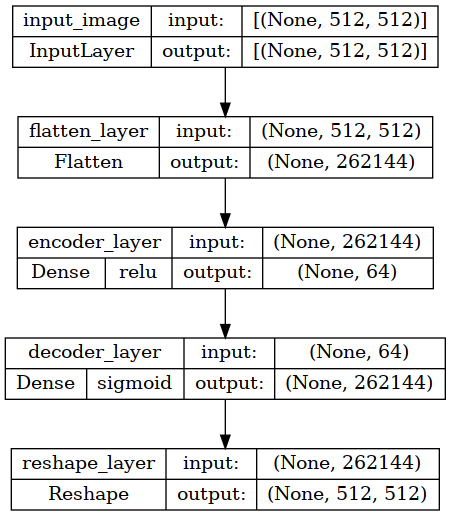

In [11]:
# Plot the model layers
tf.keras.utils.plot_model(autoencoder, to_file='./VISUALIZATIONS/autoencoder.png', show_shapes=True, show_layer_activations=True)

In [16]:
#Create the test set for endoed/decoded images (imgs/labels) pair
create_test_auto = create_datasets(dfs_100_test, fold=0, target_var=target_var, 
                img_var='path', exclude_cols=[], 
                double_input=False)

test_auto = create_test_auto.create_ds('test', resizing=img_size)

test_auto = create_test_auto.configure_for_performance(test_auto, batch_size=batch_size, train=False)


1/1 [==============================] - 0s 142ms/step


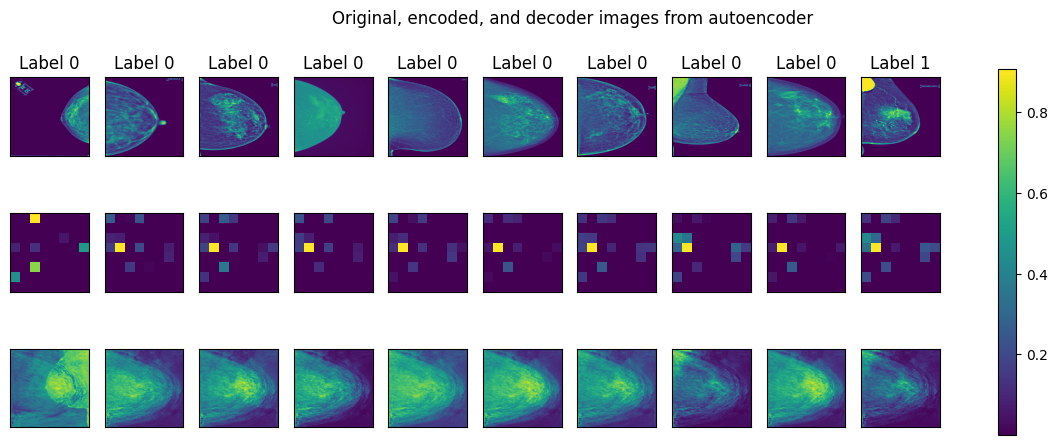

In [13]:
# Plot the input, encoded, and decoded images

for imgs, labels in test_auto.take(1):
    original_labels = labels.numpy()
    positive_labels = np.where(original_labels == 1)[0]
    negative_labels = np.where(original_labels == 0)[0]
    if len(positive_labels) > 5:
        positive_labels = positive_labels[:5]
    
    negative_labels = negative_labels[:10-len(positive_labels)]
    labels_idx = np.concatenate((negative_labels, positive_labels))

    original_imgs = imgs.numpy()
    original_imgs = original_imgs[labels_idx]
    
    original_labels = original_labels[labels_idx]

# Get the encoded image
encoded_imgs = encoder.predict(original_imgs)   
# Reshape the encoded dimensions to be a square
encoded_img_dim = (int(np.sqrt(encoding_dim)), int(np.sqrt(encoding_dim)))
# Get the decoded image
decoded_imgs = decoder.predict(encoded_imgs[:10, :])

fig, axs = plt.subplots(nrows=3, ncols=10, figsize=(15,5))

for i in range(10):
# Display original
    ax = axs[0, i]
    im = ax.imshow(original_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Label %s'%original_labels[i])

    # Display encoded
    ax = axs[1, i]
    im = ax.imshow(encoded_imgs[i].reshape(encoded_img_dim))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = axs[2, i]
    im = ax.imshow(decoded_imgs[i].reshape(img_size))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95)

fig.suptitle('Original, encoded, and decoder images from autoencoder')
plt.show()

In [24]:
# Freeze the encoder layer
for i,layer in enumerate(encoder.layers):
    print(i,layer.name, ', trainable:', layer.trainable)
    layer.trainable=False


0 input_image , trainable: True
1 flatten_layer , trainable: True
2 encoder_layer , trainable: True


#### 3.3 LOGIT WITH ENCODER PERFORMANCE

In [27]:
## Set parameters
input_size = (512, 512)
img_size = (512, 512)
n_channels = 1
batch_size = 64 # Fixed because of the encoder

#Create the model
# Design model
number_of_features = img_size

# Architecture
input_img = keras.Input((*input_size, n_channels), name='input_image')

# Logit on image with encoder

logit_auto_model = encoder(input_img, training=False)
logit_auto_model = Dense(number_of_classes, activation='sigmoid', kernel_regularizer=keras.regularizers.L2(0.015), name='logit_layer_img')(logit_auto_model)
logit_auto_model = keras.Model(inputs=input_img, outputs=logit_auto_model)

logit_auto = model_train_eval(dfs_10_test, './MODELS/logit_autoencoder', splits=splits, exclude_cols=exclude_cols,
                                basepath=basepath, img_size=img_size, n_channels=n_channels, batch_size=batch_size, 
                                random_state=random_state, n_epochs=n_epochs, double_input=False)

logit_auto_history = logit_auto.train_validate(logit_auto_model, resizing=img_size, disk_cache=False)

>>>> TRAINING FOLD 0
Epoch 1/100
35/35 [==============================] - 20s 441ms/step - loss: 71.3876 - auc: 0.5598 - precision: 0.0236 - recall: 0.9348 - f1_score: 0.0461 - val_loss: 84.9917 - val_auc: 0.4822 - val_precision: 0.0238 - val_recall: 0.6667 - val_f1_score: 0.0460 - lr: 0.0010
Epoch 2/100
35/35 [==============================] - 4s 117ms/step - loss: 44.5781 - auc: 0.5852 - precision: 0.0268 - recall: 0.6957 - f1_score: 0.0516 - val_loss: 50.7662 - val_auc: 0.4995 - val_precision: 0.0214 - val_recall: 0.5000 - val_f1_score: 0.0411 - lr: 0.0010
Epoch 3/100
35/35 [==============================] - 4s 120ms/step - loss: 35.9027 - auc: 0.5870 - precision: 0.0279 - recall: 0.6304 - f1_score: 0.0535 - val_loss: 33.9242 - val_auc: 0.4880 - val_precision: 0.0232 - val_recall: 0.5000 - val_f1_score: 0.0443 - lr: 0.0010
Epoch 4/100
35/35 [==============================] - 4s 118ms/step - loss: 27.5251 - auc: 0.5963 - precision: 0.0296 - recall: 0.6087 - f1_score: 0.0565 - val_los

In [29]:
# Save the model and history as pickle
with open('./HISTORIES/logit_auto_model.pkl', 'wb') as f:
    pickle.dump(logit_auto_history, f)
with open('./MODELS/logit_auto_model.pkl', 'wb') as f:
    pickle.dump(logit_auto_model, f);

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......functional
.........layers
............dense
...............vars
..................0
..................1
............flatten
...............vars
............input_layer
...............vars
.........vars
......input_layer
.........vars
...metrics
......auc
.........vars
............0
............1
............2
............3
......f1_score
.........vars
............0
............1
............2
............3
......mean
.........vars
............0
............1
......precision
.........vars
............0
............1
......recall
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-04-18 21:08:47         3945
variables.h5

In [30]:
# Print a summary of the mode
logit_auto_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 512, 512, 1)]     0         
                                                                 
 model_1 (Functional)        (None, 64)                16777280  
                                                                 
 logit_layer_img (Dense)     (None, 1)                 65        
                                                                 
Total params: 16,777,345
Trainable params: 65
Non-trainable params: 16,777,280
_________________________________________________________________


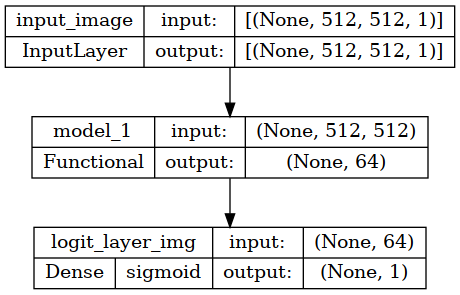

In [31]:
# Plot the model layers
tf.keras.utils.plot_model(logit_auto_model, to_file='./VISUALIZATIONS/logit_auto.png', show_shapes=True, show_layer_activations=True)

In [19]:
# Create the test data and make predictions on probabilities and classes

create_test = create_datasets(dfs_100, fold=0, target_var=target_var, 
                img_var='path', exclude_cols=[], 
                double_input=False)

test = create_test.create_ds('test', resizing=img_size)

test = create_test.configure_for_performance(test, batch_size=batch_size, train=False)


y_pred = logit_auto_model.predict(test)

y_class = np.where(y_pred >= 0.5, 1, 0)

# Save for comparison later

y_pred_auto, y_class_auto = y_pred, y_class

171/171 [==============================] - 62s 359ms/step


In [34]:
# Print activations

for imgs, labels in test.take(1):
    original_labels = labels.numpy()
    positive_labels = np.where(original_labels == 1)[0]
    negative_labels = np.where(original_labels == 0)[0]
    if len(positive_labels) > 5:
        positive_labels = positive_labels[:5]
    
    negative_labels = negative_labels[:10-len(positive_labels)]
    labels_idx = np.concatenate((negative_labels, positive_labels))

    original_imgs = imgs.numpy()
    original_imgs = original_imgs[labels_idx]
    
    original_labels = original_labels[labels_idx]

logit_auto_activations = logit_auto_model.predict(original_imgs)
#encoder_activations = encoder.predict(original_imgs)

1/1 [==============================] - 0s 94ms/step


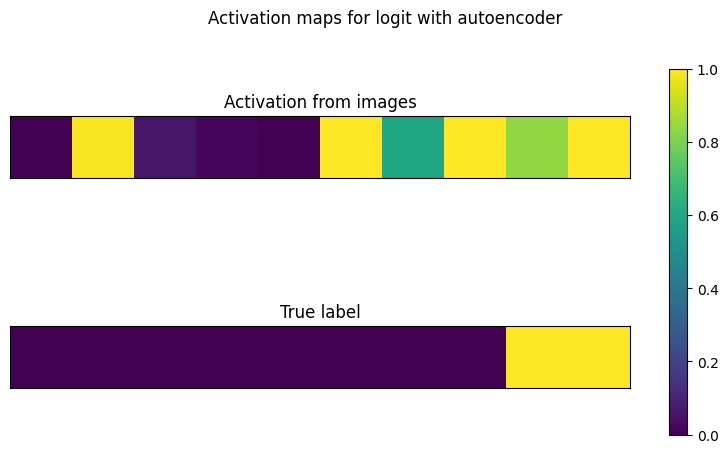

In [44]:

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,5))

# Display activation from images
ax = axs[0]
im = ax.imshow(logit_auto_activations.reshape([1, 10]))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Activation from images')

# Display true label
ax = axs[1]
im = ax.imshow(original_labels.reshape([1, 10]))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('True label')

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95)

fig.suptitle('Activation maps for logit with autoencoder')
plt.show()

In [45]:
# Evaluate the model
logit_auto_results = logit_auto_model.evaluate(test)

171/171 [==============================] - 14s 80ms/step - loss: 4.4755 - auc: 0.5043 - precision: 0.0216 - recall: 0.4327 - f1_score: 0.0411


In [20]:

y_test = [label for (imgs, label_batch) in test.as_numpy_iterator() for label in label_batch]
# Save for later
y_test_auto = y_test

# Get the confusion matrx
confusion = confusion_matrix(y_test, y_class)
print(confusion)

[[5882 4812]
 [ 139  106]]


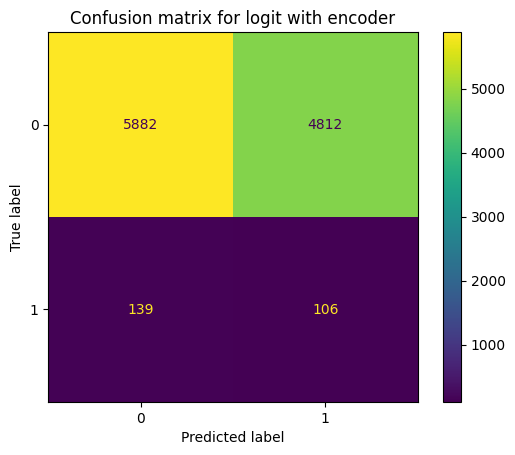

In [47]:
# Plot the confusion matrix
im = ConfusionMatrixDisplay.from_predictions(y_test, y_class)
im.ax_.set_title('Confusion matrix for logit with encoder');

In [48]:
# Print the classification report
print(classification_report(y_test, y_class))

              precision    recall  f1-score   support

           0       0.98      0.55      0.70     10694
           1       0.02      0.43      0.04       245

    accuracy                           0.55     10939
   macro avg       0.50      0.49      0.37     10939
weighted avg       0.96      0.55      0.69     10939



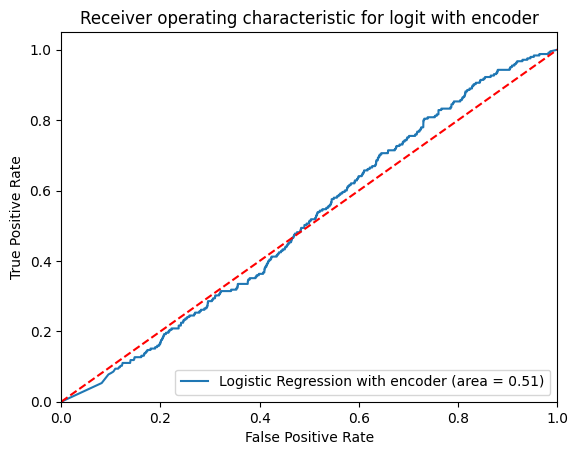

In [49]:
# Plot the ROC curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression with encoder (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for logit with encoder')
plt.legend(loc='lower right')
plt.savefig('./VISUALIZATIONS/Auto_Logit_ROC.png')
plt.show()

## 4. MODELS COMPARISON

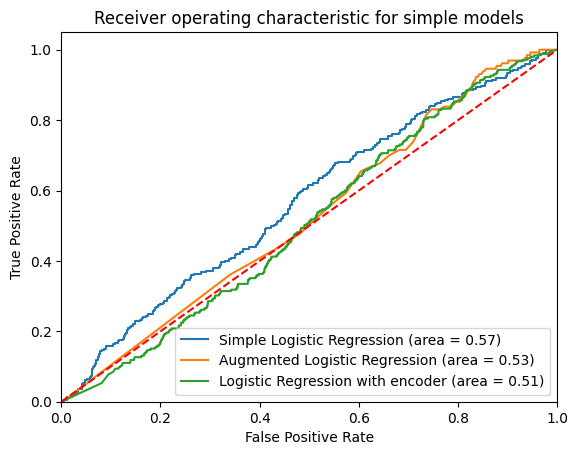

In [21]:
# Plot the ROC curve for all the models
# Simple logit
sl_logit_roc_auc = roc_auc_score(y_test_sl, y_pred_sl)
sl_fpr, sl_tpr, sl_thresholds = roc_curve(y_test_sl, y_pred_sl)
# Augmented logit
asl_logit_roc_auc = roc_auc_score(y_test_asl, y_pred_asl)
asl_fpr, asl_tpr, asl_thresholds = roc_curve(y_test_asl, y_pred_asl)
# Encoder logit
enc_logit_roc_auc = roc_auc_score(y_test_auto, y_pred_auto)
enc_fpr, enc_tpr, enc_thresholds = roc_curve(y_test_auto, y_pred_auto)

plt.figure()
plt.plot(sl_fpr, sl_tpr, label='Simple Logistic Regression (area = %0.2f)' % sl_logit_roc_auc)
plt.plot(asl_fpr, asl_tpr, label='Augmented Logistic Regression (area = %0.2f)' % asl_logit_roc_auc)
plt.plot(enc_fpr, enc_tpr, label='Logistic Regression with encoder (area = %0.2f)' % enc_logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for simple models')
plt.legend(loc='lower right')
plt.savefig('./VISUALIZATIONS/All_Logit_ROC.png')
plt.show()